# Tempo

In [40]:
import librosa
import librosa.feature


In [41]:
def load_audio(audio_path):
    x, sr = librosa.load(audio_path)
    print(type(x), type(sr))
    print(x.shape, sr)

    return x, sr

In [42]:
base_path = './Data/genres_original'
file = 'reggae/reggae.00005.wav'
audio_path = f'{base_path}/{file}'
(y, sr) = load_audio(audio_path)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


## Estimate a static tempo

A static tempo estimation in audio feature extraction provides information about the underlying tempo (i.e., the speed at which the music is played) of a given piece of music. Specifically, it indicates the fixed tempo that is assumed to be present throughout the entire piece of music.

Static tempo estimation can be useful for various music analysis tasks. For example, it can be used for beat detection, which involves identifying the rhythmic structure of a piece of music, and for rhythm analysis, which involves identifying the patterns of sound and silence in the music.

Additionally, static tempo estimation can be used in music information retrieval systems, such as music recommendation systems or music genre classification systems. This is because the tempo of a piece of music is often an important feature that can be used to classify and group music pieces into different genres or styles.

However, it is important to note that static tempo estimation provides limited information compared to dynamic tempo estimation, which takes into account the variations in tempo over time. Dynamic tempo estimation can capture more information about the rhythm and timing of the music, which can be useful for tasks such as beat tracking and music transcription.

Overall, while static tempo estimation can be a useful tool in audio feature extraction, it should be used in conjunction with other techniques to capture the full range of rhythmic and timing information present in the music.

In [43]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)
tempo


array([151.99908088])

### Static tempo with a uniform prior

Static tempo refers to a fixed tempo for an entire piece of music, as opposed to dynamic tempo which varies over time. A uniform prior is a statistical method for setting a prior belief about a variable that assumes all possible values are equally likely.

In the context of audio feature extraction, using static tempo with a uniform prior means that the tempo of the music is assumed to be fixed and constant throughout the entire piece, and that all possible tempo values are considered equally likely. This can result in a less flexible and informative feature extraction process compared to using dynamic tempo with a log-normal prior.

The use of a uniform prior in this context may not be appropriate since the tempo of music is known to follow a log-normal distribution in most cases. Therefore, using a uniform prior could lead to inaccurate and biased feature extraction results. Additionally, assuming a static tempo for a piece of music may not capture the full rhythmic complexity of the music, which can result in a loss of information.

Overall, while static tempo with a uniform prior may be useful in some limited scenarios, using dynamic tempo with a proper log-normal prior is likely to result in more informative and robust audio features for a wider range of music analysis tasks.

In [44]:
import scipy.stats

prior = scipy.stats.uniform(30, 300)  # uniform over 30-300 BPM
uniform_tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr, prior=prior)
uniform_tempo

array([161.49902344])

## Estimate the dynamic tempo


ChatGPT
A dynamic tempo estimation in audio feature extraction provides information about the variation of tempo (i.e., the speed at which the music is played) over time in a given piece of music. Unlike static tempo estimation, which assumes a fixed tempo throughout the entire piece of music, dynamic tempo estimation takes into account the variations in tempo that occur naturally in music.

Dynamic tempo estimation can be useful for various music analysis tasks, such as beat tracking and rhythm analysis. Beat tracking involves identifying the rhythmic structure of a piece of music, including the locations of beats and downbeats, while rhythm analysis involves identifying the patterns of sound and silence in the music.

Additionally, dynamic tempo estimation can be used in music transcription, which involves converting an audio recording of music into a symbolic representation, such as sheet music or a MIDI file. Dynamic tempo estimation can help to accurately capture the timing and rhythmic nuances of the music, which can be important for producing an accurate transcription.

Overall, dynamic tempo estimation provides a more complete and informative representation of the rhythmic and timing information present in music compared to static tempo estimation. It can be a powerful tool in audio feature extraction for a wide range of music analysis tasks, including beat tracking, rhythm analysis, and music transcription.

In [45]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
dynamic_tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)
dynamic_tempo



array([161.49902344, 161.49902344, 161.49902344, ..., 151.99908088,
       151.99908088, 151.99908088])

### Dynamic tempo with a proper log-normal prior

Dynamic tempo refers to the variation in tempo (i.e., the speed at which music is played) over time. A proper log-normal prior is a statistical method for setting a prior belief about a variable that has a log-normal distribution.

In the context of audio feature extraction, using dynamic tempo with a proper log-normal prior can have several benefits.

Firstly, incorporating dynamic tempo into the feature extraction process can capture more information about the rhythm and timing of the music. This can be useful for tasks such as beat detection, which relies on identifying the rhythmic structure of a piece of music.

Secondly, using a proper log-normal prior can help to regularize the feature extraction process and improve its robustness to variations in the input data. This can lead to more accurate and reliable feature extraction results.

Overall, the combination of dynamic tempo and a proper log-normal prior can result in more informative and robust audio features, which can be useful for a wide range of music analysis tasks, including genre classification, music recommendation, and audio transcription.

In [46]:
import scipy.stats
import numpy as np

prior_lognorm = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
dynamic_tempo_lognorm = librosa.feature.tempo(
    onset_envelope=onset_env,
    sr=sr,
    aggregate=None,
    prior=prior_lognorm
)
dynamic_tempo_lognorm


array([78.30255682, 78.30255682, 78.30255682, ..., 51.6796875 ,
       51.6796875 , 51.6796875 ])

## Plotting Tempo

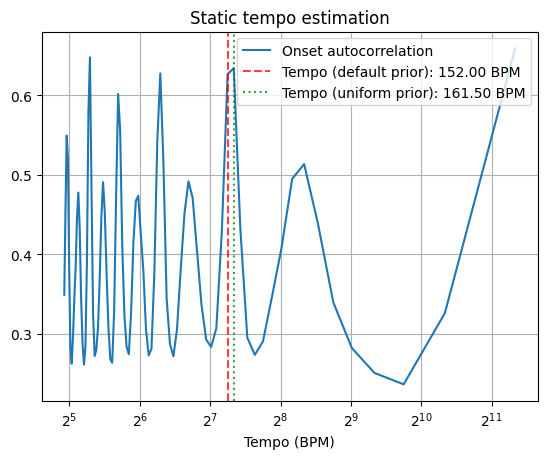

In [47]:
import matplotlib.pyplot as plt

# Convert to scalar
tempo_item = tempo.item()
uniform_tempo_item = uniform_tempo.item()

# Compute 2-second windowed autocorrelation
hop_length = 512
ac = librosa.autocorrelate(onset_env, max_size=2 * sr // hop_length)
freqs = librosa.tempo_frequencies(len(ac), sr=sr, hop_length=hop_length)

# Plot on a BPM axis.  We skip the first (0-lag) bin.
fig, ax = plt.subplots()

ax.semilogx(
    freqs[1:],
    librosa.util.normalize(ac)[1:],
    label='Onset autocorrelation',
    base=2
)

ax.axvline(
    tempo_item,
    0,
    1,
    alpha=0.75,
    linestyle='--',
    color='r',
    label='Tempo (default prior): {:.2f} BPM'.format(tempo_item)
)
ax.axvline(
    uniform_tempo_item,
    0,
    1,
    alpha=0.75,
    linestyle=':',
    color='g',
    label='Tempo (uniform prior): {:.2f} BPM'.format(uniform_tempo_item)
)
ax.set(xlabel='Tempo (BPM)', title='Static tempo estimation')
ax.grid(True)
ax.legend()

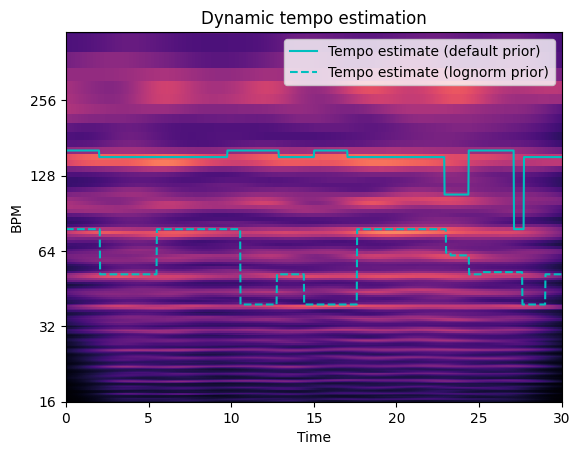

In [48]:
fig, ax = plt.subplots()

tg = librosa.feature.tempogram(
    onset_envelope=onset_env,
    sr=sr,
    hop_length=hop_length
)

librosa.display.specshow(tg, x_axis='time', y_axis='tempo', cmap='magma', ax=ax)

ax.plot(
    librosa.times_like(dynamic_tempo),
    dynamic_tempo,
    color='c',
    linewidth=1.5,
    label='Tempo estimate (default prior)'
)

ax.plot(
    librosa.times_like(dynamic_tempo_lognorm),
    dynamic_tempo_lognorm,
    color='c',
    linewidth=1.5,
    linestyle='--',
    label='Tempo estimate (lognorm prior)'
)

ax.set(title='Dynamic tempo estimation')
ax.legend()


# Tempogram

A tempogram displays a visual representation of the temporal information extracted from an audio signal, effectively highlighting its rhythmic and tempo-related features. Through the analysis of various attributes such as onset detection, beat tracking, and frequency content, a tempogram can provide valuable insights into the underlying structure and patterns within musical or speech-based recordings. This allows for more accurate classification, segmentation and understanding of complex auditory scenes.

In [49]:
hop_length = 512
onset_envelope = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=onset_strength, sr=sr, hop_length=hop_length)
tempogram


array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 5.90506082e-01,  5.90833348e-01,  5.91161520e-01, ...,
         7.73133963e-01,  7.75127019e-01,  7.77119204e-01],
       [ 2.19758067e-01,  2.20206972e-01,  2.20657392e-01, ...,
         5.32505360e-01,  5.36348737e-01,  5.40205493e-01],
       ...,
       [ 3.45786720e-18,  5.87695184e-18,  7.51945362e-18, ...,
         1.34670686e-12,  6.70624847e-13,  3.76627347e-13],
       [ 8.72150951e-18,  1.11388738e-17,  5.88348467e-18, ...,
         1.44944475e-13,  9.61622004e-14,  1.17321563e-14],
       [ 2.36671800e-18,  2.42481211e-17,  1.93839807e-17, ...,
        -5.27754123e-17, -2.46471131e-17,  1.81622275e-17]])

### Autocorrelate onset_strength

Autocorrelation is a mathematical operation that measures the similarity of a signal with a time-delayed version of itself. The autocorrelation function measures this similarity at different time lags. In the context of audio analysis, the autocorrelation of a signal can be used to estimate the tempo of the music.

In [50]:
ac_global = librosa.autocorrelate(onset_envelope, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
ac_global

array([1.        , 0.65907302, 0.32593228, 0.23644404, 0.25077879,
       0.28209719, 0.3394998 , 0.44005772, 0.51348423, 0.49487464,
       0.40780703, 0.34549385, 0.2905006 , 0.27346211, 0.2950961 ,
       0.43271881, 0.6341416 , 0.62652699, 0.42846342, 0.30674807,
       0.28352589, 0.29278072, 0.33703821, 0.40554731, 0.47104567,
       0.49182391, 0.45152852, 0.37979776, 0.30531812, 0.27164616,
       0.28691323, 0.34425913, 0.51492415, 0.62759733, 0.54116131,
       0.37545634, 0.28113806, 0.27285568, 0.30579215, 0.37934441,
       0.42598586, 0.47373664, 0.46691525, 0.41549582, 0.32703128,
       0.27440688, 0.28355874, 0.3237183 , 0.4099019 , 0.55524462,
       0.60160646, 0.47244057, 0.32849181, 0.26347935, 0.26793304,
       0.30732357, 0.37375583, 0.45172765, 0.49072758, 0.44598402,
       0.36585281, 0.30658534, 0.27953432, 0.27215709, 0.32466834,
       0.48320045, 0.64770744, 0.5782877 , 0.38971979, 0.28320999,
       0.2611871 , 0.28804991, 0.34502324, 0.43119693, 0.47765

In [51]:
tempo = librosa.feature.tempo(onset_envelope=onset_envelope, sr=sr, hop_length=hop_length)[0]
tempo

151.99908088235293

### Plot Tempogram

The first subplot displays the onset_strength signal against time. Onset strength is a measure of the intensity of musical events, such as the start of a note or chord. The plot shows the onset strength over time, with higher values indicating stronger onsets.

The second subplot displays a spectrogram-like representation of the tempogram signal, which is a measure of the local tempo of the music. The x-axis shows time, and the y-axis shows tempo in beats per minute (BPM). The color of each pixel represents the strength of the local tempo at that time and tempo. The horizontal white line shows the estimated tempo value.

The third subplot displays the mean local autocorrelation and global autocorrelation of the tempogram signal against lag time in seconds. Autocorrelation measures the similarity of a signal with a delayed version of itself. The plot shows the autocorrelation of the tempogram signal at different time lags, with higher values indicating greater similarity between the signal and its delayed version. The solid line shows the mean local autocorrelation, which measures the similarity between the signal and its delayed version at the same tempo. The dashed line shows the global autocorrelation, which measures the overall similarity between the signal and its delayed version across all tempos.

The fourth subplot displays the mean local autocorrelation and global autocorrelation of the tempogram signal against tempo in BPM. The plot shows the autocorrelation of the tempogram signal at different tempos, with higher values indicating greater similarity between the signal and its delayed version at that tempo. The solid line shows the mean local autocorrelation, and the dashed line shows the global autocorrelation. The vertical black line shows the estimated tempo value.


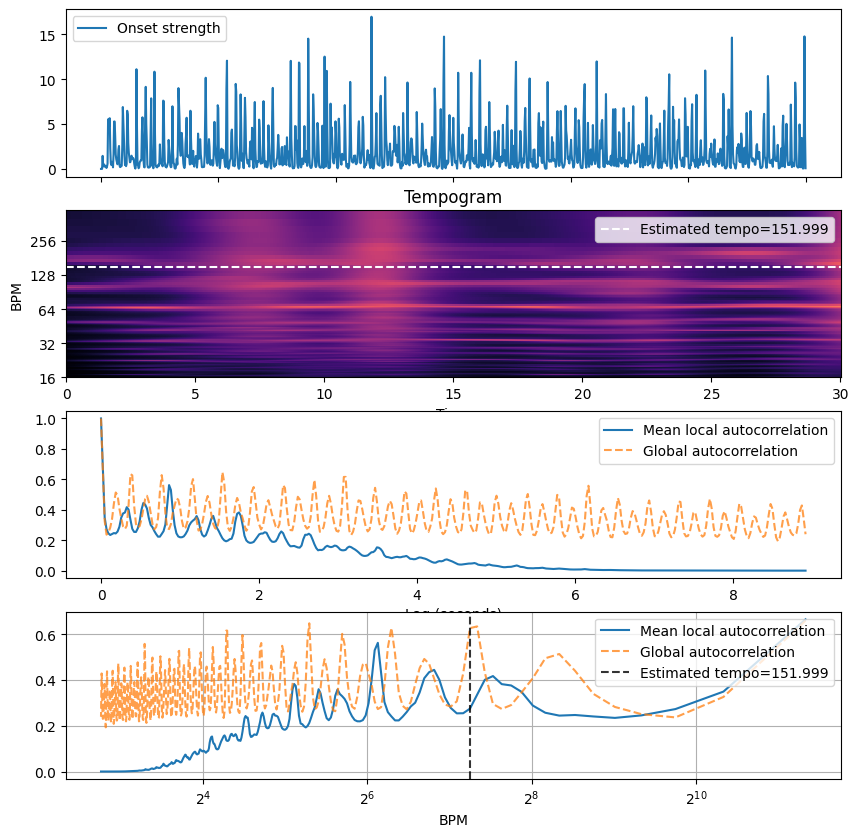

In [52]:
fig, ax = plt.subplots(nrows=4, figsize=(10, 10))
times = librosa.times_like(onset_envelope, sr=sr, hop_length=hop_length)

ax[0].plot(times, onset_envelope, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(
    tempogram,
    sr=sr,
    hop_length=hop_length,
    x_axis='time',
    y_axis='tempo',
    cmap='magma',
    ax=ax[1]
)

ax[1].axhline(tempo, color='w', linestyle='--', alpha=1, label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')

x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr, num=tempogram.shape[0])
ax[2].plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
ax[2].plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
ax[2].set(xlabel='Lag (seconds)')
ax[2].legend(frameon=True)

freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
ax[3].semilogx(freqs[1:], np.mean(tempogram[1:], axis=1), label='Mean local autocorrelation', base=2)
ax[3].semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75, label='Global autocorrelation', base=2)
ax[3].axvline(tempo, color='black', linestyle='--', alpha=.8, label='Estimated tempo={:g}'.format(tempo))
ax[3].legend(frameon=True)
ax[3].set(xlabel='BPM')
ax[3].grid(True)


## Fourier Tempogram

A Fourier tempogram is a type of audio feature representation that can be used to estimate the tempo of music. It is based on the short-time Fourier transform (STFT) of an audio signal, which decomposes the signal into its frequency components over time.

To create a Fourier tempogram, the STFT is calculated over short overlapping windows of the audio signal, and then the power spectrum of each window is summed over frequency bins to produce a tempogram. The tempogram is a 2D representation of the audio signal, with time along one axis and tempo (measured in beats per minute) along the other axis. Each point in the tempogram represents the strength of the signal at a particular time and tempo.

The Fourier tempogram is useful because it provides a time-varying estimate of the tempo of the music, which can change over the course of a song. This can be particularly useful for applications such as automatic music transcription or beat tracking, where it is important to accurately estimate the tempo of the music. However, the Fourier tempogram can be sensitive to noise and may not work well for music with complex rhythms or tempo changes.


In [53]:
hop_length = 512
onset_envelope = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.fourier_tempogram(onset_envelope=onset_envelope, sr=sr, hop_length=hop_length)
# Compute the auto-correlation tempogram, unnormalized to make comparison easier
ac_tempogram = librosa.feature.tempogram(onset_envelope=onset_envelope, sr=sr, hop_length=hop_length, norm=None)
ac_tempogram


array([[ 5.99872801e+02,  6.09749832e+02,  6.19656823e+02, ...,
         8.40931073e+02,  8.32764176e+02,  8.24539195e+02],
       [ 4.31103475e+02,  4.37694986e+02,  4.44295898e+02, ...,
         5.13979364e+02,  5.08371055e+02,  5.02740277e+02],
       [ 2.56214143e+02,  2.59614251e+02,  2.63008377e+02, ...,
         1.87253114e+02,  1.84621838e+02,  1.81995843e+02],
       ...,
       [-3.85379111e-14, -3.33501154e-15,  1.34141575e-14, ...,
         1.34266193e-10,  8.67854859e-11,  2.44493031e-11],
       [-5.10997879e-14, -2.90516561e-14, -1.57857213e-14, ...,
         1.24067061e-11,  1.13893238e-11,  2.41764250e-12],
       [-2.60316178e-14, -4.76165536e-15, -6.29946624e-15, ...,
        -1.86042692e-14,  3.91400660e-15,  6.60934439e-14]])

[Text(0.5, 1.0, 'Autocorrelation tempogram')]

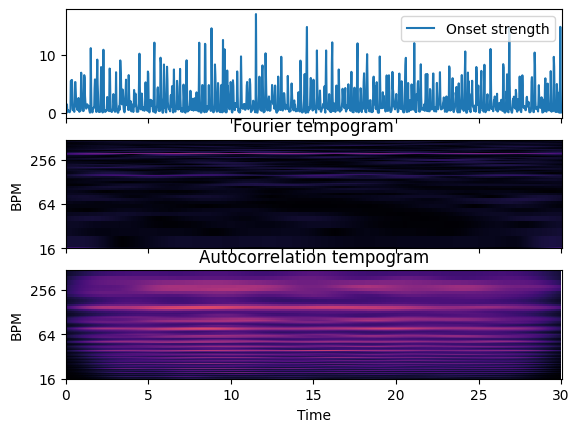

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, sharex=True)

ax[0].plot(librosa.times_like(onset_envelope), onset_envelope, label='Onset strength')
ax[0].legend(frameon=True)
ax[0].label_outer()

librosa.display.specshow(
    np.abs(tempogram),
    sr=sr,
    hop_length=hop_length,
    x_axis='time',
    y_axis='fourier_tempo',
    cmap='magma',
    ax=ax[1]
)

ax[1].set(title='Fourier tempogram')
ax[1].label_outer()
librosa.display.specshow(
    ac_tempogram,
    sr=sr,
    hop_length=hop_length,
    x_axis='time',
    y_axis='tempo',
    cmap='magma',
    ax=ax[2]
)

ax[2].set(title='Autocorrelation tempogram')


## Tempogram Ratio

Tempogram ratio can be used to estimate the metrical strength of a musical beat, which refers to how strongly a particular beat in a rhythm is emphasized. The tempogram ratio is calculated by dividing the amplitude of the local maximum in the tempogram by the amplitude of the global maximum in the tempogram.

In practical terms, the tempogram ratio provides a measure of the periodicity of a musical rhythm, with higher values indicating a stronger emphasis on the beat. This can be useful for tasks such as beat tracking and audio segmentation, where it is important to accurately identify the boundaries between musical sections or individual beats.

The tempogram ratio can be particularly useful in scenarios where the tempo of the music is variable or where there are multiple competing rhythms or beats in the music. By focusing on the most prominent beat in the rhythm, the tempogram ratio can provide a more reliable estimate of the underlying structure of the music.

In [57]:
tempogram = librosa.feature.tempogram(y=y, sr=sr)
tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
tgr

array([[0.21795288, 0.21752704, 0.21710769, ..., 0.20593034, 0.20542155,
        0.20491433],
       [0.33777521, 0.33859533, 0.33940968, ..., 0.28843677, 0.28731217,
        0.28618958],
       [0.27862976, 0.27906128, 0.27949109, ..., 0.24175491, 0.24080969,
        0.23987092],
       ...,
       [0.20671517, 0.20808767, 0.20945674, ..., 0.24674473, 0.24512558,
        0.24349836],
       [0.30562489, 0.30703083, 0.30841969, ..., 0.12234342, 0.12108647,
        0.11983487],
       [0.13512758, 0.13631488, 0.13750216, ..., 0.17285409, 0.17128904,
        0.16972194]])

[Text(0.5, 1.0, 'Tempogram ratio')]

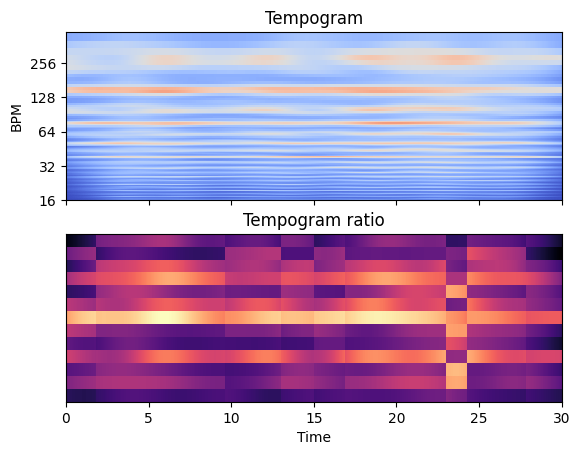

In [56]:
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(tempogram, x_axis='time', y_axis='tempo', ax=ax[0])
librosa.display.specshow(tgr, x_axis='time', ax=ax[1])
ax[0].label_outer()
ax[0].set(title="Tempogram")
ax[1].set(title="Tempogram ratio")
